# T2 SME0104 - Cálculo Numérico
## Decodificador de sinais DTMF

Alunos: 
- Kauê Hunnicutt Bazilli - 11212226
- Matheus Vieira Gonçalves - 11200397
- Pedro Henrique dias Junqueira de Souza - 11294312

# Explicação
O projeto desenvolvido foi um decodificador de sinais DTMF (Dual-tone Multi-Frequency). 

Os sinais DTMF são os sons tons que tocam ao digitarmos números telefônicos. Cada número é representado por dois tons, sendo um de baixa e um de alta frequência. O conjunto desses dois tons é decodificado ao chegar na central telefônica, possibilitando converter o áudio desses sons no conjunto de caracteres digitados. 

Outro jeito de entender, para quem gosta de música, é interpretando cada um dos sinais DTMF é como uma harmonia composta por duas notas tocadas ao mesmo tempo. Cada uma dessas harmonias representa um dígito teclado em um telefone/celular.

O objetivo do projeto desenvolvido é criar um decodificador capaz de interpretar o som recebido utilizando o métodos dos mínimos quadrados, possibilitando obter os caracteres pressionados a partir dos sons DTMF.

# Revisar

Como o áudio é um sinal periódico, ele pode ser representado por uma série de Fourier, que é uma soma de senos e cossenos. Nosso objetivo é dado um som, achar uma aproximação da série de Fourier através do método dos mínimos quadrados e, a partir dessa aproximação, determinar quais os tons sendo tocados e inferir o valor digitado.

Essencialmente, precisamos:
1) Gravar o sinal de áudio
2) Isolar os sons tocados (ignorar o ruído de fundo do áudio)
3) Para cada um dos sons, achar uma soma de senoides que descreve esse som
4) Usar as somas de senoides encontradas para determinar as frequências tocadas
5) Sabendo as frequências, sabemos qual o dígito tocado

In [5]:
# Remover os comentários para instalar as bibliotecas necessárias
# import sys
# !{sys.executable} -m pip install sounddevice
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib

import numpy as np
from scipy.ndimage import zoom
import sounddevice as sd
import matplotlib.pyplot as plt
import math

### Aqui, definimos diversas constantes que serão utilizadas ao longo do código.

In [6]:
SAMPLE_RATE = 44000  # taxa de gravação
REC_TIME = 10.0  # segundos
FRAMES = int(REC_TIME * SAMPLE_RATE)  # quantidade de frames da gravação
CHANNELS = 1  # quantidade de canais, 1 significa mono

# menor quantidade de tempo significativo durante a gravação
DELTA_T = 1.0 / SAMPLE_RATE

# Frequências DTMF
DTMF_LOW_FREQUENCIES = np.array([697, 770, 852, 941])  # Hz
DTMF_HIGH_FREQUENCIES = np.array([1209, 1336, 1477, 1633])  # Hz

DTMF_FREQUENCIES = np.concatenate(
    [DTMF_LOW_FREQUENCIES, DTMF_HIGH_FREQUENCIES])  # Hz

SILENCE_THRESHOLD_PERCENT = 20
SILENCE_THRESHOLD_PERCENT = (SILENCE_THRESHOLD_PERCENT + 100) / 100

"""
        1209Hz	1336Hz	1477Hz	1633Hz
697Hz	    1	    2	    3	    A
770Hz	    4	    5	    6	    B
852Hz	    7	    8	    9	    C
941Hz	    *	    0	    #	    D
"""

DTMF_DICT = np.array(
    [['1', '2', '3', 'A'],
     ['4', '5', '6', 'B'],
     ['7', '8', '9', 'C'],
     ['*', '0', '#', 'D']])

### Nesse ponto, o áudio é gravado e armazenado como um array do numpy. O áudio a ser gravado tem a duração e o número de amostras especificados.

In [7]:
# inicia a gravação do áudio
sound_wave = sd.rec(frames=FRAMES,
                    samplerate=SAMPLE_RATE,
                    channels=CHANNELS)

sd.wait()  # espera a gravação encerrar
SOUND_WAVE_ROWS, SOUND_WAVE_COLS = sound_wave.shape
print(type(sound_wave), sound_wave.shape)

<class 'numpy.ndarray'> (440000, 1)


### Reprodução do áudio gravado:

In [8]:
sd.play(sound_wave, samplerate=SAMPLE_RATE)  # toca o audio gravado
sd.wait()  # espera o audio encerrar

### Tratamento dos dados do array de modo a isolar apenas os trechos desejados do áudio gravado. Nesse ponto, nosso objetivo é isolar os trechos com cada um dos sons gravados. Para isso, aplicamos uma série de filtros:

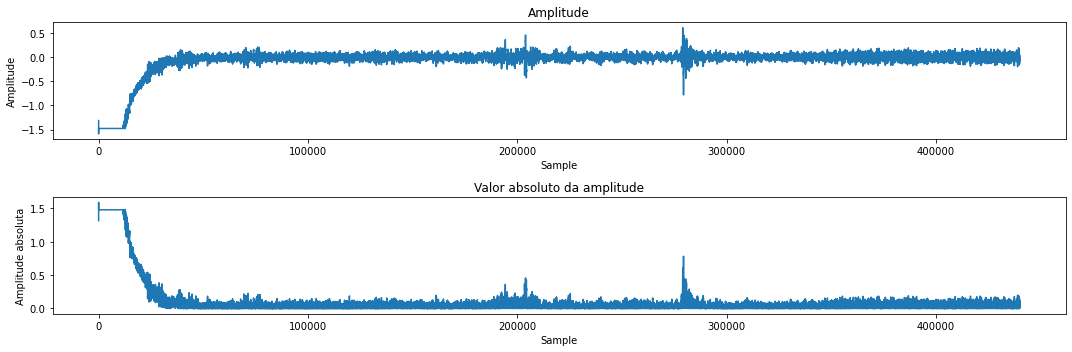

In [22]:
fig, ax = plt.subplots(2, figsize=(15,5))
ax[0].set_xlabel("Sample")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Amplitude")
ax[0].plot(sound_wave)

ax[1].set_xlabel("Sample")
ax[1].set_ylabel("Amplitude absoluta")
ax[1].set_title("Valor absoluto da amplitude")
ax[1].plot(np.abs(sound_wave))

plt.tight_layout()

### Agora, ao invés de utilizarmos os valores gravados, utilizamos a média móvel dos valores, resultando em um sinal mais limpo e polido.

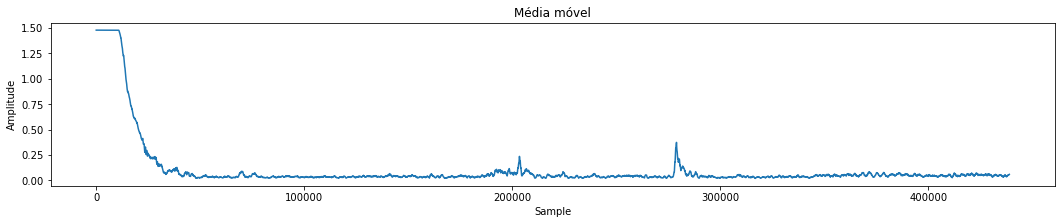

In [29]:
 # Faz uma média móvel dos dados utilizando uma janela de 1000 dados
def moving_average(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# média móvel dos valores absolutos
filtered_sound_wave = moving_average(np.abs(sound_wave))

fig, ax = plt.subplots(figsize=(18,3))
ax.set_title("Média móvel")
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")
ax.plot(filtered_sound_wave)

### Agora, é definido o limiar de ruído, para saber o que é considerado "silêncio" e não é relevante. Trechos com a intensidade do sinal abaixo desse limiar não são considerados como parte de um som.

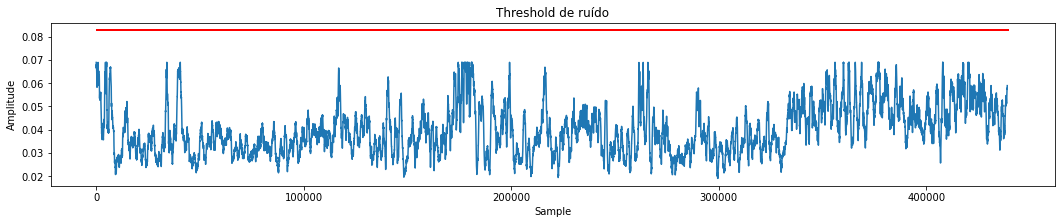

In [34]:
#rejeita outliers com base na mediana dos dados
def reject_outliers(data, m = 3.): 
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

#removendo outliers da média móvel para encontra o threshold dos dados
silence_wave = reject_outliers(filtered_sound_wave)
silence_wave = zoom(silence_wave,len(filtered_sound_wave)/len(silence_wave))

#threshold equivalente a 20% a mais que o maior pico do silêncio
silence_threshold = np.max(silence_wave) * SILENCE_THRESHOLD_PERCENT; 

fig, ax = plt.subplots(figsize=(18,3))
ax.set_title("Threshold de ruído")
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")
ax.plot(silence_wave)
ax.hlines(silence_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)

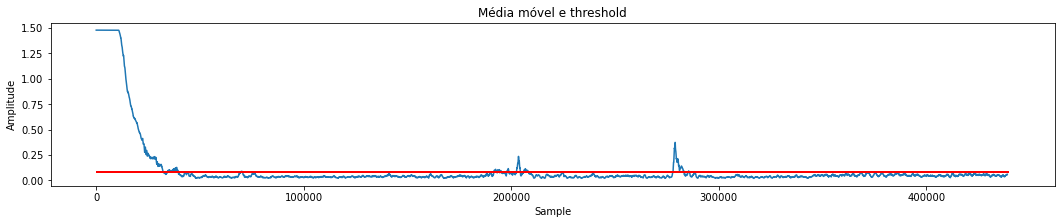

In [35]:
# visualização da média móvel e threshold

fig, ax = plt.subplots(figsize=(18,3))
ax.set_title("Média móvel e threshold")
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")
ax.plot(filtered_sound_wave)
ax.hlines(silence_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)

### Agora, a partir desses dados, são encontrados os intervalos nos quais os sons foram emitidos

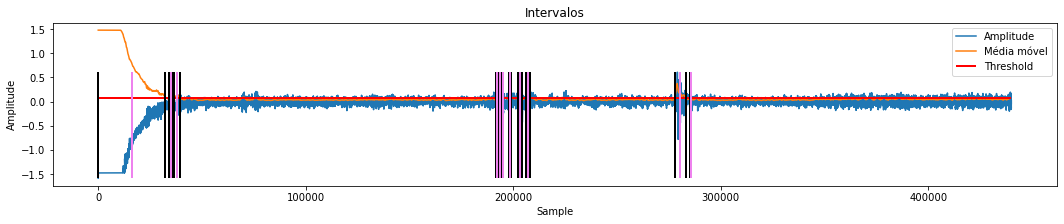

In [43]:
# encontra um intervalo de pontos maior que uma constante
def find_interval(data, max, start=0):
    begin = np.argmax(data[start:] > max)+start
    end = np.argmax(data[begin:] < max)
    return begin, end+begin


# encontra todos os intervalos maiores que uma determinada constante
def find_all_intervals(data, threshold):
    intervals = []
    end = 0
    begin = 0
    while(True):
        begin, end = find_interval(data, threshold, end)
        if end == begin:
            break
        if end - begin > 500:
            intervals.append([begin, end])
    return np.array(intervals)


intervals = find_all_intervals(filtered_sound_wave, silence_threshold)

fig, ax = plt.subplots(figsize=(18,3))
ax.set_title("Intervalos")
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")

ax.plot(sound_wave, label="Amplitude")
ax.plot(filtered_sound_wave, label="Média móvel")
ax.hlines(silence_threshold, xmin=-1, xmax=[len(sound_wave)], color='r', linewidth=2, label="Threshold")
ax.legend()

for begin, end in intervals:
    ax.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    ax.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    ax.vlines((begin+end)/2, ymin=[np.min(sound_wave)],
              ymax=[np.max(sound_wave)], color='violet', linewidth=2)

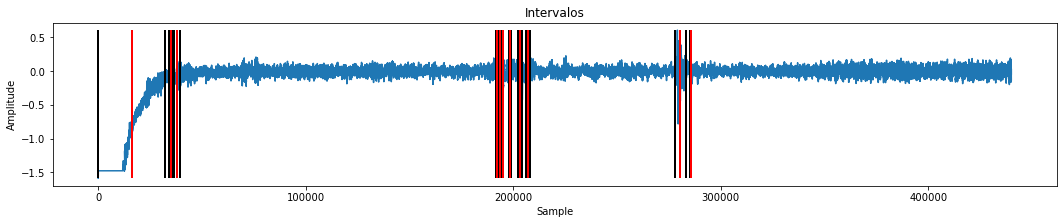

In [44]:
# visualização menos poluída dos dados
fig, ax = plt.subplots(figsize=(18,3))
ax.set_title("Intervalos")
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")

ax.plot(sound_wave)

for begin, end in intervals:
    ax.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    ax.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    ax.vlines((begin+end)/2, ymin=[np.min(sound_wave)],
              ymax=[np.max(sound_wave)], color='red', linewidth=2)

### Agora, todos os intervalos são ajustados para terem o mesmo tamanho, sendo esse o tamanho do menor intervalo encontrado

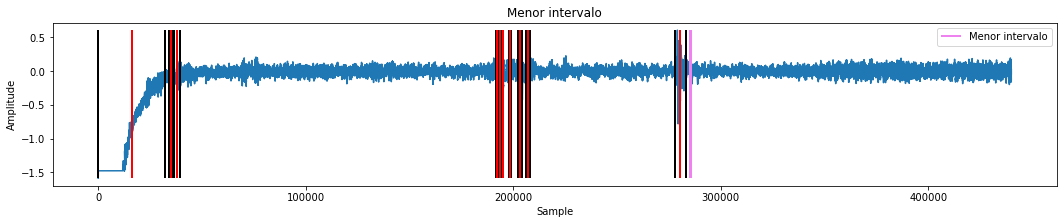

In [46]:
# encontrando o menor dos intervalos
intervals_sizes = [end - begin for begin, end in intervals]
intervals_midpoints = [(end + begin)/2 for begin, end in intervals]

min_interval_idx = np.argmin(intervals_sizes)
MINOR_INTERVAL_SIZE = intervals_sizes[min_interval_idx]

fig, ax = plt.subplots(figsize=(18,3))
ax.set_title("Menor intervalo")
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")

ax.plot(sound_wave)

for begin, end in intervals:
    ax.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    ax.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    ax.vlines((begin+end)/2, ymin=[np.min(sound_wave)],
              ymax=[np.max(sound_wave)], color='red', linewidth=2)

ax.vlines(intervals[min_interval_idx][0], ymin=[np.min(sound_wave)], ymax=[
    np.max(sound_wave)], color='violet', linewidth=2, label="Menor intervalo")
ax.vlines(intervals[min_interval_idx][1], ymin=[np.min(sound_wave)], ymax=[
    np.max(sound_wave)], color='violet', linewidth=2)

ax.legend()

[[15860, 16372], [34897, 35409], [37680, 38192], [191889, 192401], [193567, 194079], [194679, 195191], [198130, 198642], [203177, 203689], [206790, 207302], [280261, 280773], [285230, 285742]]


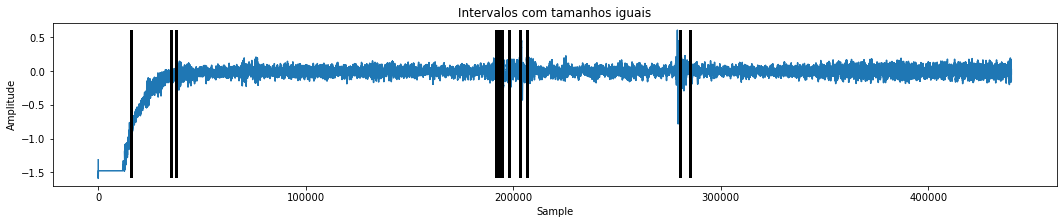

In [47]:
# normalizando os intervalos de acordo com o menor
filtered_intervals = [[int(midpoint - MINOR_INTERVAL_SIZE/2), int(midpoint +
                       MINOR_INTERVAL_SIZE/2)] for midpoint in intervals_midpoints]

print(filtered_intervals)

fig, ax = plt.subplots(figsize=(18,3))
ax.set_title("Intervalos com tamanhos iguais")
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")

ax.plot(sound_wave)

for begin, end in filtered_intervals:
    ax.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    ax.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)

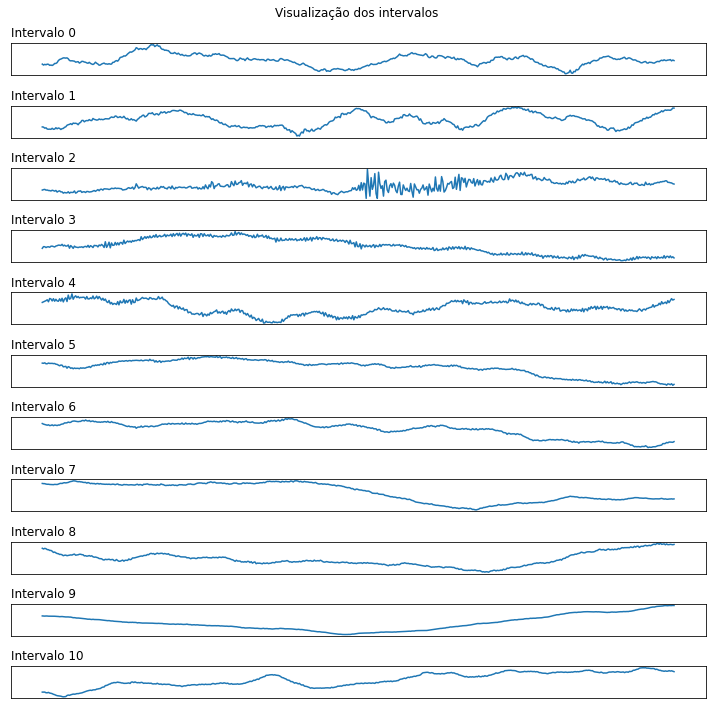

In [63]:
# plotando cada um dos intervalos encontrados
tones_sound_waves = [sound_wave[begin:end]
                     for begin, end in filtered_intervals]

fig, ax = plt.subplots(len(tones_sound_waves), figsize=(10,10))
fig.suptitle("Visualização dos intervalos")

for i, tone_sound_wave in enumerate(tones_sound_waves):
    ax[i].set_xticks([])
    ax[i].set_yticks([100])
    ax[i].set_title(f"Intervalo {i}", loc="left")
    ax[i].plot(tone_sound_wave)
    
plt.tight_layout()

### Agora, entram os mínimos quadrados:

O audio gravado pode ser descrito como:

$$
S(t) = \sum_{n=1}^{8} A_n \times \sin{ (\phi_n 2\pi t + \sigma_n)}
$$

Sendo $A$ a amplitude de cada frequência $n$, e $\sigma_n$ a fase de cada um dos sinais. Utilizando o seno da soma, podemos desenvolver essa expressão para:


$$
S(t) = \sum_{n=1}^{8} A_n [\sin{(\phi_n 2\pi t)}\cos{(\sigma_n)} + \sin{(\sigma_n)}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} [\underbrace{A_n \cos(\sigma_n)}_{x_{2n-1}}\sin{(\phi_n 2\pi t)}
 + \overbrace{A_n \sin{(\sigma_n)}}^{x_{2n}}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} x_{2n-1}\sin{(\phi_n 2\pi t)} + \sum_{n=1}^{8} x_{2n}\cos{(\phi_n2\pi t)}, \; A_n = \sqrt{x_{2n}^2 + x_{2n-1}^2}
$$

Assim, podemos ver que teremos 16 equações com diferentes coeficientes para serem encontrados. Podemos fazer isso aplicando o **método dos mínimos quadrados**. 

# Revisar
Aqueles que tiverem as maiores amplitudes serão os relacionados ao digito que buscamos.

In [51]:
#simplificação, ao invés de criarmos 16 funções diferentes podemos criar apenas essa
def mmq(time, n):
    frequency = int(n/2)
    val = DTMF_FREQUENCIES[frequency] * math.pi * 2 * time
    return math.sin(val) if (n % 2 == 0) else math.cos(val)


A = np.zeros(shape=(MINOR_INTERVAL_SIZE, 16))
for i in range(0, MINOR_INTERVAL_SIZE):
    for j in range(0, 16):
        A[i][j] = mmq(i * DELTA_T, j)


Utilizando as equações normais temos que $\hat{x}$ é uma solução para $ Ax = B <=> A^{T}A \hat{x} = A^{T}b$ 

In [52]:
def solve_mmq_system(A, B):
    A_T = A.T
    A_T_dot_A = A_T @ A
    A_T_dot_b = A_T @ B
    return np.linalg.solve(A_T_dot_A, A_T_dot_b).T[0]


In [53]:
def get_amplitude_array(coeficiente_matrix):
    return np.array([(coeficiente_matrix[i]**2 + coeficiente_matrix[i+1]**2)**(1/2) for i in range(0, 16, 2)])


def get_low_and_high_amplitude_array(amplitude_array):
    return amplitude_array[0:4], amplitude_array[4:8]


def get_max_frequency_idxs(low_freq_amplitude, high_freq_amplitude):
    return low_freq_amplitude.argmax(), high_freq_amplitude.argmax()


for tone_sound_wave in tones_sound_waves:
    X = solve_mmq_system(A, tone_sound_wave)
    amplitudes_array = get_amplitude_array(X)
    low, high = get_low_and_high_amplitude_array(amplitudes_array)
    low_max, high_max = get_max_frequency_idxs(low, high)
    print(f"{DTMF_LOW_FREQUENCIES[low_max]}Hz & {DTMF_HIGH_FREQUENCIES[high_max]}Hz : {DTMF_DICT[low_max][high_max]}")


697Hz & 1209Hz : 1
697Hz & 1336Hz : 2
697Hz & 1336Hz : 2
697Hz & 1477Hz : 3
770Hz & 1477Hz : 6
770Hz & 1336Hz : 5
770Hz & 1336Hz : 5
770Hz & 1209Hz : 4
852Hz & 1209Hz : 7
852Hz & 1336Hz : 8
852Hz & 1477Hz : 9
852Hz & 1477Hz : 9
